# Load Thumos 2014 I3D features

In [3]:
import numpy as np
import glob
import utils.utils as util
import time
import os

class Dataset():
    def __init__(self, args):
        self.trainidx = []
        self.dataset_name = args.dataset_name
        self.path_to_annotations = os.path.join(args.annotation_path, args.dataset_name + '-Annotations/')
        self.path_to_features = os.path.join(args.I3D_path, self.dataset_name + '-I3D-JOINTFeatures.npy')
        self.labels = np.load(self.path_to_annotations + 'labels_all.npy')     # Specific to Thumos14
        self.classlist = np.load(self.path_to_annotations + 'classlist.npy')
        self.subset = np.load(self.path_to_annotations + 'subset.npy')
        self.testidx = []
        self.classwiseidx = []
        self.train_test_idx()
        self.currenttestidx = 0
        self.t_max = args.max_seqlen
        self.num_class = args.num_class
        self.classwise_feature_mapping()
        self.batch_size = args.batch_size
        self.feature_size = args.feature_size
        self.features = np.load(self.path_to_features, encoding='bytes')
        self.segments = np.load(self.path_to_annotations + 'segments.npy')
        self.labels_multihot = [util.strlist2multihot(labs,self.classlist) for labs in self.labels]


    def train_test_idx(self):
        for i, s in enumerate(self.subset):
            if s.decode('utf-8') == 'validation':   # Specific to Thumos14
                self.trainidx.append(i)
            else:
                self.testidx.append(i)

    def classwise_feature_mapping(self):
        for category in self.classlist:
            idx = []
            for i in self.trainidx:
                for label in self.labels[i]:
                    if label == category.decode('utf-8'):
                        idx.append(i); break;
            self.classwiseidx.append(idx)


    def load_data(self, n_similar=3, is_training=True):
        if is_training==True:
            features = []
            labels = []
            idx = []

            # Load similar pairs
            rand_classid = np.random.choice(len(self.classwiseidx), size=n_similar)
            for rid in rand_classid:
                rand_sampleid = np.random.choice(len(self.classwiseidx[rid]), size=2)
                idx.append(self.classwiseidx[rid][rand_sampleid[0]])
                idx.append(self.classwiseidx[rid][rand_sampleid[1]])

            # Load rest pairs
            rand_sampleid = np.random.choice(len(self.trainidx), size=self.batch_size-2*n_similar)
            for r in rand_sampleid:
                idx.append(self.trainidx[r])
          
            return np.array([util.process_feat(self.features[i], self.t_max) for i in idx]), np.array([self.labels_multihot[i] for i in idx])

        else:
            labs = self.labels_multihot[self.testidx[self.currenttestidx]]
            feat = self.features[self.testidx[self.currenttestidx]]

            if self.currenttestidx == len(self.testidx)-1:
                done = True; self.currenttestidx = 0
            else:
                done = False; self.currenttestidx += 1
         
            return np.array(feat), np.array(labs), done


In [4]:
import utils.options
import torch
import torch.nn as nn

class Args():
    def __init__(self):
        self.lr = 0.0001
        self.dataset_name = 'Thumos14reduced'
        self.num_class = 20
        self.feature_size = 2048
        self.batch_size = 24
        self.max_seqlen = 750
        self.model_name = 'weakloc'
        self.pretrained_ckpt = None
        self.max_iter = 50000
        self.num_similar = 3
        self.checkpoint_path = './checkpoint/'
        self.annotation_path = './annotations/'
        self.I3D_path = './I3D_features/'

args = Args()

# Load the dataset
thomoas_i3d_dataset = Dataset(args)

In [279]:
# Test Thumas Dataset

# Randomly extract 10 video clips' I3D feature
features, labels = thomoas_i3d_dataset.load_data(n_similar=args.num_similar, is_training=True)

# Features are alingned in 750 frames all the same, now trunk it into actual max length
seq_len = np.sum(np.max(np.abs(features), axis=2) > 0, axis=1)
features = features[:,:np.max(seq_len),:]

# Convert to CUDA tensor
features = torch.from_numpy(features).float().to('cuda')
labels = torch.from_numpy(labels).float().to('cuda')

# Temporal Pooling Module

In [364]:
# Attention Module
# Test

class Attention_Module(nn.Module):
    """Args:
    feature_dim: dimension of the feature from I3D model.
    """

    def __init__(self, feature_dim):
        super(Attention_Module, self).__init__()
        
        self.feature_dim = feature_dim
        self.fc0 = nn.Linear(feature_dim, 1024)
        self.fc1 = nn.Linear(1024, 256)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(2048, 20)

    def forward(self, features_list):
        """Build the attention module.

        Args:
        features_list: (batch_size, num_frame, feat_depth)

        Returns:
        The attention weights, weigted features
        """
        
        attention_weights = []
        weighted_features = []
        
        # Iterate through batch
        for idx, video_features in enumerate(features_list):
                        
            # Trunk feature into real length
            seq_len = (torch.abs(video_features).max(dim=1)[0] > 0).sum().tolist()
            video_features = video_features[: seq_len, :]
            
            # Iterate through video segments
            output = self.sigmoid(self.fc2(self.relu(self.fc1(self.relu(self.fc0(video_features))))))

            # Temporal Pool
            weighted_pooling = (output*video_features).sum(0)/video_features.shape[0]
            
            # Save weights/features
            output = output.reshape(output.shape[0])
            attention_weights.append(output)
            weighted_features.append(weighted_pooling)
            
        # Reshape to tensor
        weighted_features = torch.stack(weighted_features)
#         attention_weights = torch.stack(attention_weights)
        
        predict = self.sigmoid(self.fc3(weighted_features))
        
        return attention_weights, weighted_features, predict


def l1_norm(inputs):
    norm_value = torch.zeros(len(inputs)).cuda()
    for idx, vector in enumerate(inputs):
        norm_value[idx] = torch.norm(torch.abs(vector), p=1)
    return norm_value.sum()


def multi_to_single(labels):
    l = []
    for lab in labels:
        l.append(lab.tolist().index(1))
    return torch.from_numpy(np.asarray(l)).cuda()

# Attention Module
# Test

# class Attention_Module(nn.Module):
#     """Args:
#     feature_dim: dimension of the feature from I3D model.
#     """

#     def __init__(self, feature_dim):
#         super(Attention_Module, self).__init__()
        
#         self.feature_dim = feature_dim
#         self.fc1 = nn.Linear(2048, 256)
#         self.relu = nn.ReLU(inplace=True)
#         self.fc2 = nn.Linear(256, 20)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, features_list):
#         """Build the attention module.

#         Args:
#         features_list: (batch_size, num_frame, feat_depth)

#         Returns:
#         The attention weights, weigted features
#         """
        
#         weighted_features = []
        
#         # Iterate through batch
#         for idx, video_features in enumerate(features_list):
                        
#             # Trunk feature into real length
#             seq_len = (torch.abs(video_features).max(dim=1)[0] > 0).sum().tolist()
#             video_features = video_features[: seq_len, :]
            

#             # Temporal Pool
#             weighted_pooling = video_features.sum(0)/video_features.shape[0]
            
#             # Save weights/features
#             weighted_features.append(weighted_pooling)
            
#         # Reshape to tensor
#         weighted_features = torch.stack(weighted_features)
        
#         predict = self.sigmoid((self.fc2(self.relu(self.fc1(weighted_features)))))
        
#         return _, _, predict



In [373]:
# Attention Module Testing
model = Attention_Module(feature_dim=2048)
model.cuda()
print('Attention Model loaded')

# Optimizer
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Softmax Loss Define
softmax_loss = nn.BCELoss()
# margin_loss = nn.MultiLabelSoftMarginLoss()
# cross_loss = nn.CrossEntropyLoss() 

Attention Model loaded


# Training

In [ ]:
from tensorboardX import SummaryWriter
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

writer = SummaryWriter()

for epoch in range(args.max_iter):
    # Randomly extract 10 video clips' I3D feature
    features, labels = thomoas_i3d_dataset.load_data(n_similar=args.num_similar)

    # Features are alingned in 750 frames all the same, now trunk it into max length
    seq_len = np.sum(np.max(np.abs(features), axis=2) > 0, axis=1)
    features = features[:,:np.max(seq_len),:]

    # Convert to CUDA tensor
    features = torch.from_numpy(features).float().to('cuda')
    labels = torch.from_numpy(labels).float().to('cuda')
    
    # Prediction and Loss
    attention_weights, weighted_features, output = model(features)
    
#     s_loss_value = softmax_loss(output, labels).detach().cpu().tolist()
    loss = softmax_loss(output, labels) + 0.00001*l1_norm(attention_weights)
#     loss = cross_loss(output, multi_to_single(labels).long())
    
    # Back Propogation
    optimizer.zero_grad() 
    loss.backward()  
    optimizer.step()
    
    # Testing performances
#     if epoch % 100 == 0:
        # Load test set and conduct validation
        
        
    # Save checkpoint
    if epoch % 5000 == 0 and epoch is not 0:
        # Reduce lr 
        lr /= 2
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        # Checkpoint structure
        model_state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }

        torch.save(model_state, os.path.join(args.checkpoint_path, 'model_epoch_{:03}.pth'.format(epoch)))
    

    # Print out training loss
    loss_value = loss.detach().cpu().tolist()
    writer.add_scalar('runs/', loss_value, epoch)
    
    if epoch % 100 == 0:
        print('Epoch:{:03}, Loss: {:02}'.format(epoch, loss_value))

        print(attention_weights[0][0:10].tolist())
        plt.plot(output[0].tolist(), linestyle='--', marker='o', color='b')
        plt.plot(labels[0].tolist(), linestyle='--', marker='o', color='r')
        plt.show()

# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
writer.close()

# Load Pre-trained Model for testing


In [375]:
model = Attention_Module(feature_dim=2048)
checkpoint = torch.load('./checkpoint/model_epoch_15000_bce.pth')
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']
model.eval()
model.cuda()
print('model loaded')

model loaded


In [474]:
features, labels, _ = thomoas_i3d_dataset.load_data(n_similar=args.num_similar, is_training=False)
features = torch.from_numpy(features.reshape(1, -1, 2048)).cuda()
labels = torch.from_numpy(labels).cuda()

In [475]:
attention_weights, weighted_features, predict = model(features)

(0.9, 1.01)

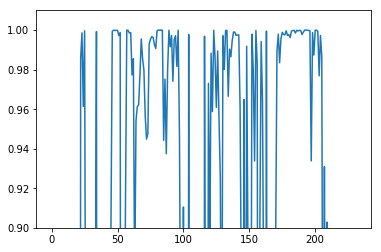

In [476]:
plt.plot(attention_weights[0].tolist())
plt.ylim([0.90,1.01])
